In [3]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
np.set_printoptions(precision=3)

### Methods 

In [5]:
from enum import Enum

class Mode(Enum):
    base = 0
    inc = 1
    inc_update = 2
    inc_update_neg = 3

In [6]:
def analyze_trace(trs):
    results = []
    for tr in trs:
        if len(tr) == 4:
            trial_idxs, scores, label, pred = tr
        elif len(tr) == 5:
            trial_idxs, scores, label, pred, enroll_pred = tr
        else:
            raise NotImplementedError

        result = dict()
        result["fpr"] = round(np.count_nonzero((pred == 1) & (label == 0)) / len(label), 4)
        result["fnr"] = round(np.count_nonzero((pred == 0) & (label == 1)) / len(label), 4)
        result["error"] = round(np.count_nonzero(pred != label) / len(label), 4)
#         result["neg_scores"] = round(np.mean(scores[label == 0]), 4) 

        if len(tr) == 5:
            result["n_adt_enroll"] = np.count_nonzero(enroll_pred != -1)
             # 1: correctly enrolled, 0: incorrectly enrolled, -1: not enrolle
            if np.count_nonzero(enroll_pred != -1) == 0:
                result["enr_error"] = 0
            else:
                result["enr_error"] = round(np.count_nonzero(enroll_pred == 0) \
                                            / np.count_nonzero(enroll_pred != -1), 4)
        results.append(result)

    return results

In [7]:
def compute_metrics(results):
        mean_error = np.mean([dic['error'] for dic in results])
        mean_fpr = np.mean([dic['fpr'] for dic in results])
        mean_fnr = np.mean([dic['fnr'] for dic in results])
        
        return mean_error, mean_fpr, mean_fnr

In [8]:
def print_result(result_dir):
    modes = os.listdir(result_dir)
    setting = result_dir.split("/")[-2]
    modes = sorted(modes, key=lambda x: Mode[x].value)

    print(setting)
    for mode in modes:
        mode_dir = os.path.join(result_dir, mode)
        with open(mode_dir + "/trace.pkl", "rb") as f:
            trace = pickle.load(f)
        meta_info = pd.read_pickle(mode_dir + "/meta_info_df.pkl")
        results = {"adapt":[], "test":[], "ood":[], "test_s_err":[], 'ood_s_err':[]}
        for tr in trace:
            adapt_result, test_result, ood_result = analyze_trace(tr)
            results["adapt"].append(adapt_result)
            results["test"].append(test_result)
            results["ood"].append(ood_result)

            results["test_s_err"].append(meta_info['test_s_err'])
            results["ood_s_err"].append(meta_info['ood_s_err'])
#             print("s_acc: {}".format(meta_info['s_pred_acc']))
            
        for trial_type in ["adapt", "test", "ood"]:
            mean_error, mean_fpr, mean_fnr = compute_metrics(results[trial_type])
            msg = ("[{:20s}]: {:.4f}(err), {:.4f}(fpr), {:.4f}(fnr)".format(
                "/".join([mode, trial_type]), mean_error, mean_fpr, mean_fnr))
            if trial_type != "adapt":
                err = np.mean(results[trial_type + "_s_err"])
                msg += " {:.4f}(s_err)".format(err)
            print(msg)
        print("-"*80)
    print("="*80)

In [9]:
print_result("adaptive_sv_system/test/FS3_ENR3_QUE7/")

FS3_ENR3_QUE7
[base/adapt          ]: 0.0278(err), 0.0187(fpr), 0.0091(fnr)
[base/test           ]: 0.0274(err), 0.0207(fpr), 0.0067(fnr) 0.4387(s_err)
[base/ood            ]: 0.0474(err), 0.0474(fpr), 0.0000(fnr) 1.0000(s_err)
--------------------------------------------------------------------------------
[inc_update_neg/adapt]: 0.0209(err), 0.0151(fpr), 0.0058(fnr)
[inc_update_neg/test ]: 0.0222(err), 0.0153(fpr), 0.0070(fnr) 0.0045(s_err)
[inc_update_neg/ood  ]: 0.0495(err), 0.0495(fpr), 0.0000(fnr) 0.0062(s_err)
--------------------------------------------------------------------------------


In [272]:
def summary_result(result_dir):
    modes = os.listdir(result_dir)
    setting = result_dir.rstrip("/").split("/")[-1]
    modes = sorted(modes, key=lambda x: Mode[x].value)

    summary = []
    for mode in modes:
        mode_dir = os.path.join(result_dir, mode)
        with open(mode_dir + "/trace.pkl", "rb") as f:
            trace = pickle.load(f)
        results = {"adapt":[], "test":[], "ood":[]}
        for tr in trace:
            adapt_result, test_result, ood_result = analyze_trace(tr)
            results["adapt"].append(adapt_result)
            results["test"].append(test_result)
            results["ood"].append(ood_result)
        
        for trial_type in ["adapt", "test", "ood"]:
            mean_error, mean_fpr, mean_fnr = compute_metrics(results[trial_type])
            summary.append([setting, mode, trial_type, mean_error])
            
    return summary

In [254]:
def summary_result(result_dir):
    modes = os.listdir(result_dir)
    setting = result_dir.rstrip("/").split("/")[-1]
    modes = sorted(modes, key=lambda x: Mode[x].value)

    summary = []
    errors = {'adapt':[], 'test':[], 'ood':[]}
    for mode in modes:
        mode_dir = os.path.join(result_dir, mode)
        with open(mode_dir + "/trace.pkl", "rb") as f:
            trace = pickle.load(f)
        results = {"adapt":[], "test":[], "ood":[]}
        for tr in trace:
            adapt_result, test_result, ood_result = analyze_trace(tr)
            results["adapt"].append(adapt_result)
            results["test"].append(test_result)
            results["ood"].append(ood_result)
        
        for trial_type in ["adapt", "test", "ood"]:
            mean_error, mean_fpr, mean_fnr = compute_metrics(results[trial_type])
            errors[trial_type] += [mean_error]
            
    for trial_type in ["adapt", "test", "ood"]:
        summary.append([setting, trial_type] + errors[trial_type])
            
    return summary

In [255]:
settings = os.listdir("adaptive_sv_system/enr306_closedset_out/")

In [256]:
results = []
for setting in settings:
    results += summary_result("adaptive_sv_system/enr306_closedset_out/"+setting)

In [258]:
summary_df = pd.DataFrame.from_records(results, columns=['setting', 'trial_type', 'base_err', 'inc_err', 'inc_udt_err', 'inc_udt_neg_err'])

In [259]:
summary_df.index = summary_df.apply(lambda x: '/'.join([x.setting, x.trial_type]), axis=1)

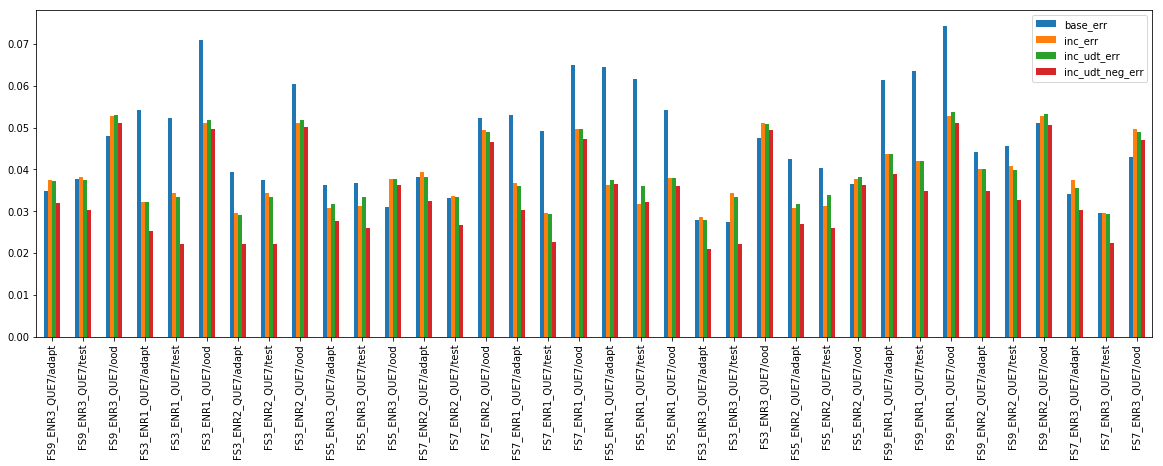

In [267]:
summary_df.plot.bar(figsize=(20,6))

## Interpret traces

In [279]:
print_result("adaptive_sv_system/test/FS3_ENR3_QUE7/")

FS3_ENR3_QUE7
[base/adapt          ]: 0.0278(err), 0.0187(fpr), 0.0091(fnr)
[base/test           ]: 0.0274(err), 0.0207(fpr), 0.0067(fnr)
[base/ood            ]: 0.0474(err), 0.0474(fpr), 0.0000(fnr)
--------------------------------------------------------------------------------
[inc/adapt           ]: 0.0286(err), 0.0229(fpr), 0.0057(fnr)
[inc/test            ]: 0.0343(err), 0.0269(fpr), 0.0075(fnr)
s_acc: 0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    0.988095
12    0.984375
13    0.956522
14    0.978261
15    0.990196
16    1.000000
17    1.000000
18    1.000000
19    1.000000
20    0.990000
21    1.000000
22    1.000000
23    1.000000
24    0.988372
25    1.000000
26    1.000000
27    1.000000
28    1.000000
29    1.000000
Name: s_pred_acc, dtype: float64
[inc/ood             ]: 0.0510(err), 0.0510(fpr), 0.0000(fnr)
-------------------------------------------

KeyError: 's_pred_acc'

## Gathering information after proceeding verifications

trace = [adapt_tr, test_tr, ood_tr]  
tr = trial_idxs, scores, label, pred 또는   
tr = trial_idxs, scores, label, pred, enroll_pred  

In [51]:
keys = np.array(pickle.load(open("xvector_embeds/sv_keys.pkl", "rb")))

In [439]:
def get_info_trace(trace):
    if len(trace) == 4:
        idxs, _, label, pred, = trace
    elif len(trace) == 5:
        idxs, _, label, pred, _ = trace
    ids = [keys[int(idx)] for idx in idxs]
    data = pd.DataFrame({"id":ids, "idx":idxs, "pred":pred, "label":label}, dtype=np.int64)

    return data

In [452]:
trace = pickle.load(open("./adaptive_sv_system/test/inc_neg/Set3_Enr5_Que7/trace.pkl", "rb"))

In [454]:
meta_info = pd.read_pickle("./adaptive_sv_system/test/inc_neg/Set3_Enr5_Que7/meta_info_df.pkl")

In [456]:
adapt_data, test_data, ood_data = list(map(get_info_trace, trace[0]))

In [457]:
adapt_data.to_csv("adapt_data.csv", index=None)
test_data.to_csv("test_data.csv", index=None)
ood_data.to_csv("ood_data.csv", index=None)

In [463]:
enr_idx = meta_info.iloc[0].enr_idxs

In [466]:
keys[enr_idx]

array(['id10363-oOER7ITQrjA-00004', 'id10363-ycU0RxYQN6w-00010',
       'id10363-oTbZXWMTGhs-00010', 'id10363-tMIjFefXiQQ-00009',
       'id10363-oTbZXWMTGhs-00015'], dtype='<U25')

In [465]:
np.save("enroll_idx.npy", enr_idx)

In [472]:
adapt_result, test_result, ood_result = analyze_trace(trace[0])

In [476]:
adapt_result

{'fpr': 0.0,
 'fnr': 0.0164,
 'error': 0.0164,
 'n_adt_enroll': 108,
 'enr_error': 0.0}

In [474]:
test_result

{'fpr': 0.0, 'fnr': 0.0039, 'error': 0.0039}

In [475]:
ood_result

{'fpr': 0.082, 'fnr': 0.0, 'error': 0.082}

### Sanity Check
meta info와 trace의 순서가 잘 일치하는지 체크

In [217]:
trial = pickle.load(open("trials/enr306_closedset/3/trials.pkl", "rb"))